In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from pathlib import Path
from copy import deepcopy
import numpy as np
import pandas as pd

import sklearn
from sklearn.datasets import make_circles # To generate the dataset

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import TensorBoard

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D  # 3D plots

import seaborn as sns
# plotting style
sns.set_style('white')

# for reproducibility
np.random.seed(seed=42)

In [2]:
# get GPU list if it exists
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    # GPU memory allocating GPU and increse if it needs
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using GPU


In [7]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
results_path = Path('results')
if not results_path.exists():
    results_path.mkdir()

In [3]:
# Input Data

# dataset params
N = 50000
factor = 0.1
noise = 0.1

# generate data
X, y = make_circles(n_samples=N, shuffle=True, factor=factor, noise=noise)

# define outcome matrix
Y = np.zeros((N, 2))
for c in [0, 1]:
    Y[y == c, c] = 1
f'Shape of: X: {X.shape} | Y: {Y.shape} | y: {y.shape}'

'Shape of: X: (50000, 2) | Y: (50000, 2) | y: (50000,)'

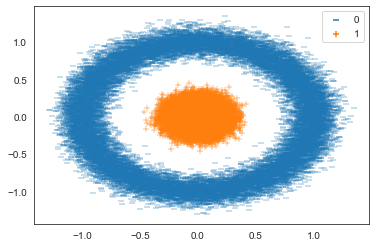

In [8]:
# Visualize Data
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, style=y, markers=['_', '+']);

In [9]:
# Build Keras Model
model = Sequential([
    Dense(units=3, input_shape=(2,), name='hidden'),
    Activation('sigmoid', name='logistic'),
    Dense(2, name='output'),
    Activation('softmax', name='softmax'),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden (Dense)              (None, 3)                 9         
                                                                 
 logistic (Activation)       (None, 3)                 0         
                                                                 
 output (Dense)              (None, 2)                 8         
                                                                 
 softmax (Activation)        (None, 2)                 0         
                                                                 
Total params: 17
Trainable params: 17
Non-trainable params: 0
_________________________________________________________________


In [10]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

tb_callback = TensorBoard(log_dir=results_path / 'tensorboard', histogram_freq=1, write_graph=True,
                          write_images=True)

training=model.fit(X, Y, epochs=50, validation_split=.2, batch_size=128, verbose=1, callbacks=[tb_callback])

Epoch 1/50
313/313 [==============================] - 4s 5ms/step - loss: 0.7127 - accuracy: 0.5760 - val_loss: 0.6971 - val_accuracy: 0.6874
Epoch 2/50
313/313 [==============================] - 1s 4ms/step - loss: 0.6952 - accuracy: 0.6155 - val_loss: 0.6941 - val_accuracy: 0.4497
Epoch 3/50
313/313 [==============================] - 1s 5ms/step - loss: 0.6937 - accuracy: 0.5753 - val_loss: 0.6934 - val_accuracy: 0.6947
Epoch 4/50
313/313 [==============================] - 1s 4ms/step - loss: 0.6928 - accuracy: 0.6249 - val_loss: 0.6924 - val_accuracy: 0.4893
Epoch 5/50
313/313 [==============================] - 1s 4ms/step - loss: 0.6919 - accuracy: 0.6679 - val_loss: 0.6911 - val_accuracy: 0.6207
Epoch 6/50
313/313 [==============================] - 1s 4ms/step - loss: 0.6902 - accuracy: 0.6605 - val_loss: 0.6893 - val_accuracy: 0.6914
Epoch 7/50
313/313 [==============================] - 1s 4ms/step - loss: 0.6873 - accuracy: 0.7013 - val_loss: 0.6855 - val_accuracy: 0.6974
Epoch 

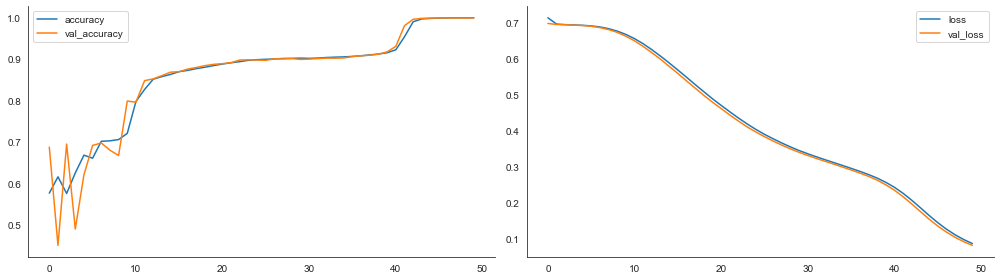

In [11]:
fig, axes = plt.subplots(ncols=2, figsize=(16,8))
pd.DataFrame(training.history)[['accuracy', 'val_accuracy']].plot(ax=axes[0])
pd.DataFrame(training.history)[['loss', 'val_loss']].plot(ax=axes[1])
sns.despine()
fig.tight_layout();

In [12]:
# Get Weights
hidden = model.get_layer('hidden').get_weights()
[t.shape for t in hidden]

[(2, 3), (3,)]

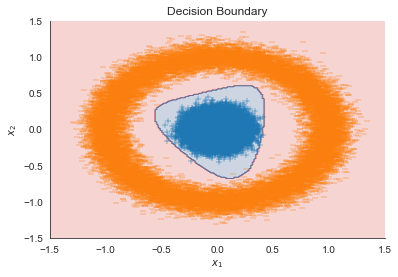

In [13]:
# Plot Decision Boundary
n_vals = 200
x1 = np.linspace(-1.5, 1.5, num=n_vals)
x2 = np.linspace(-1.5, 1.5, num=n_vals)
xx, yy = np.meshgrid(x1, x2)  # create the grid

X_ = np.array([xx.ravel(), yy.ravel()]).T
y_hat = np.argmax(model.predict(X_), axis=1)

# Create a color map to show the classification colors of each grid point
cmap = ListedColormap([sns.xkcd_rgb["pale red"], sns.xkcd_rgb["denim blue"]])

# Plot the classification plane with decision boundary and input samples
plt.contourf(xx, yy, y_hat.reshape(n_vals, -1), cmap=cmap, alpha=.25)

# Plot both classes on the x1, x2 plane
data = pd.DataFrame(X, columns=['$x_1$', '$x_2$']).assign(Class=pd.Series(y).map({0:'negative', 1:'positive'}))
sns.scatterplot(x='$x_1$', y='$x_2$', hue='Class', data=data, style=y, markers=['_', '+'], legend=False)
sns.despine()
plt.title('Decision Boundary');

In [14]:
%load_ext tensorboard
%tensorboard --logdir results/tensorboard/

Launching TensorBoard...